In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

- Drop players with more than one team
- Index with tuple for Rk & Player
- Drop the following columns:
     - Unuseful information: Rk, GT, MaxVotes, Tm, Pos
     - Correlation with another feature: FG_tot, 3PA_tot, 2PA_tot, FGA_rank_tot
     - With target information: Votes
- LabelEncode for Player, Pos and Team
- Separate types of columns

In [4]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [5]:
pipe = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [6]:
df = pipe.fit_transform(df)

In [7]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [8]:
len(df[df['Season'] > 2015]) / len(df)

0.17507805847289243

In [9]:
val_df = df[df['Season'] > 2015]
dev_df = df[df['Season'] <= 2015]

In [10]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .25)

In [11]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [12]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [13]:
mlflow.set_experiment('NBA MVP prediction linear model')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/1', experiment_id='1', lifecycle_stage='active', name='NBA MVP prediction linear model', tags={}>

In [14]:
# param_grid = {
#     'max_depth': [6, 8, 10], 
#     'colsample_bytree': [.5], 
#     'learning_rate': [.1],
#     'subsample': [1, .8, .6],
#     'n_estimators': [1000]
#     }

In [15]:
with mlflow.start_run():
    model = LinearRegression(normalize = True)

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10, )

    model.fit(X_train, y_train)

    predicted_targets = mod.predict_model(model, datasets)

    # mod.log_params_mlflow_xgb(best_params, sampling_ratio)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_linear_coef(model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_))

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model

In [16]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.066203,0.067011,0.064163
R2,0.693137,0.299743,-0.285639


In [17]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [18]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.593460
263,2016,Kawhi Leonard,0.484,0.333781
222,2016,LeBron James,0.482,0.426514
452,2016,Russell Westbrook,0.371,0.447719
126,2016,Kevin Durant,0.112,0.498004
348,2016,Chris Paul,0.082,0.265607
167,2016,Draymond Green,0.038,0.242426
266,2016,Damian Lillard,0.020,0.088507
178,2016,James Harden,0.007,0.346090


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.684027
173,2017,James Harden,0.746,0.587653
261,2017,Kawhi Leonard,0.495,0.371547
221,2017,LeBron James,0.330,0.459635
425,2017,Isaiah Thomas,0.080,0.228610
98,2017,Stephen Curry,0.051,0.274403
16,2017,Giannis Antetokounmpo,0.007,0.244411
453,2017,John Wall,0.007,0.227688
100,2017,Anthony Davis,0.002,0.259015


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.590659
249,2018,LeBron James,0.731,0.551172
122,2018,Anthony Davis,0.441,0.337692
298,2018,Damian Lillard,0.205,0.253313
508,2018,Russell Westbrook,0.075,0.342450
16,2018,Giannis Antetokounmpo,0.074,0.233625
143,2018,Kevin Durant,0.065,0.254738
130,2018,DeMar DeRozan,0.032,0.093445
7,2018,LaMarcus Aldridge,0.006,0.082750


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.482965
207,2019,James Harden,0.768,0.571700
184,2019,Paul George,0.352,0.177428
270,2019,Nikola Jokić,0.210,0.229100
124,2019,Stephen Curry,0.173,0.077519
305,2019,Damian Lillard,0.068,0.211873
155,2019,Joel Embiid,0.049,0.166926
150,2019,Kevin Durant,0.025,0.216894
301,2019,Kawhi Leonard,0.013,0.139486


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.530003
251,2020,LeBron James,0.746,0.386364
199,2020,James Harden,0.363,0.479718
134,2020,Luka Dončić,0.198,0.334942
294,2020,Kawhi Leonard,0.166,0.241091
123,2020,Anthony Davis,0.081,0.299915
396,2020,Chris Paul,0.026,0.134057
297,2020,Damian Lillard,0.023,0.270991
262,2020,Nikola Jokić,0.018,0.205324


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.595372
146,2021,Joel Embiid,0.580,0.206807
116,2021,Stephen Curry,0.449,0.149674
12,2021,Giannis Antetokounmpo,0.345,0.304446
396,2021,Chris Paul,0.138,0.175139
130,2021,Luka Dončić,0.042,0.259731
297,2021,Damian Lillard,0.038,0.174849
421,2021,Julius Randle,0.020,0.155885
439,2021,Derrick Rose,0.010,0.051733


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
2,2016,Jordan Adams,0.0,0.052716
5,2016,Alexis Ajinça,0.0,0.008082
7,2016,LaMarcus Aldridge,0.0,0.075802
8,2016,Cliff Alexander,0.0,0.023598
9,2016,Lavoy Allen,0.0,0.009215
...,...,...,...,...
536,2021,Delon Wright,0.0,0.108993
537,2021,Thaddeus Young,0.0,0.067834
538,2021,Trae Young,0.0,0.164041


In [19]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
97,2016,DeMarcus Cousins,0.0,0.153041
242,2016,DeAndre Jordan,0.0,0.147660
334,2016,J.J. O'Brien,0.0,0.125664
446,2016,John Wall,0.0,0.111112
17,2017,Carmelo Anthony,0.0,0.106790
...,...,...,...,...
524,2021,Kenrich Williams,0.0,0.111970
526,2021,Patrick Williams,0.0,0.121056
530,2021,Dylan Windler,0.0,0.102165


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

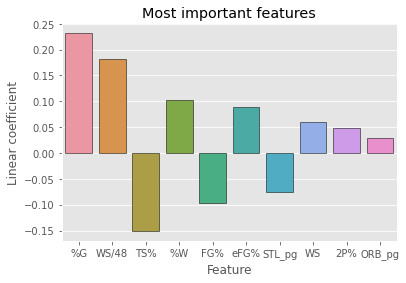

In [20]:
mod.display_linear_coef(model)

In [21]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

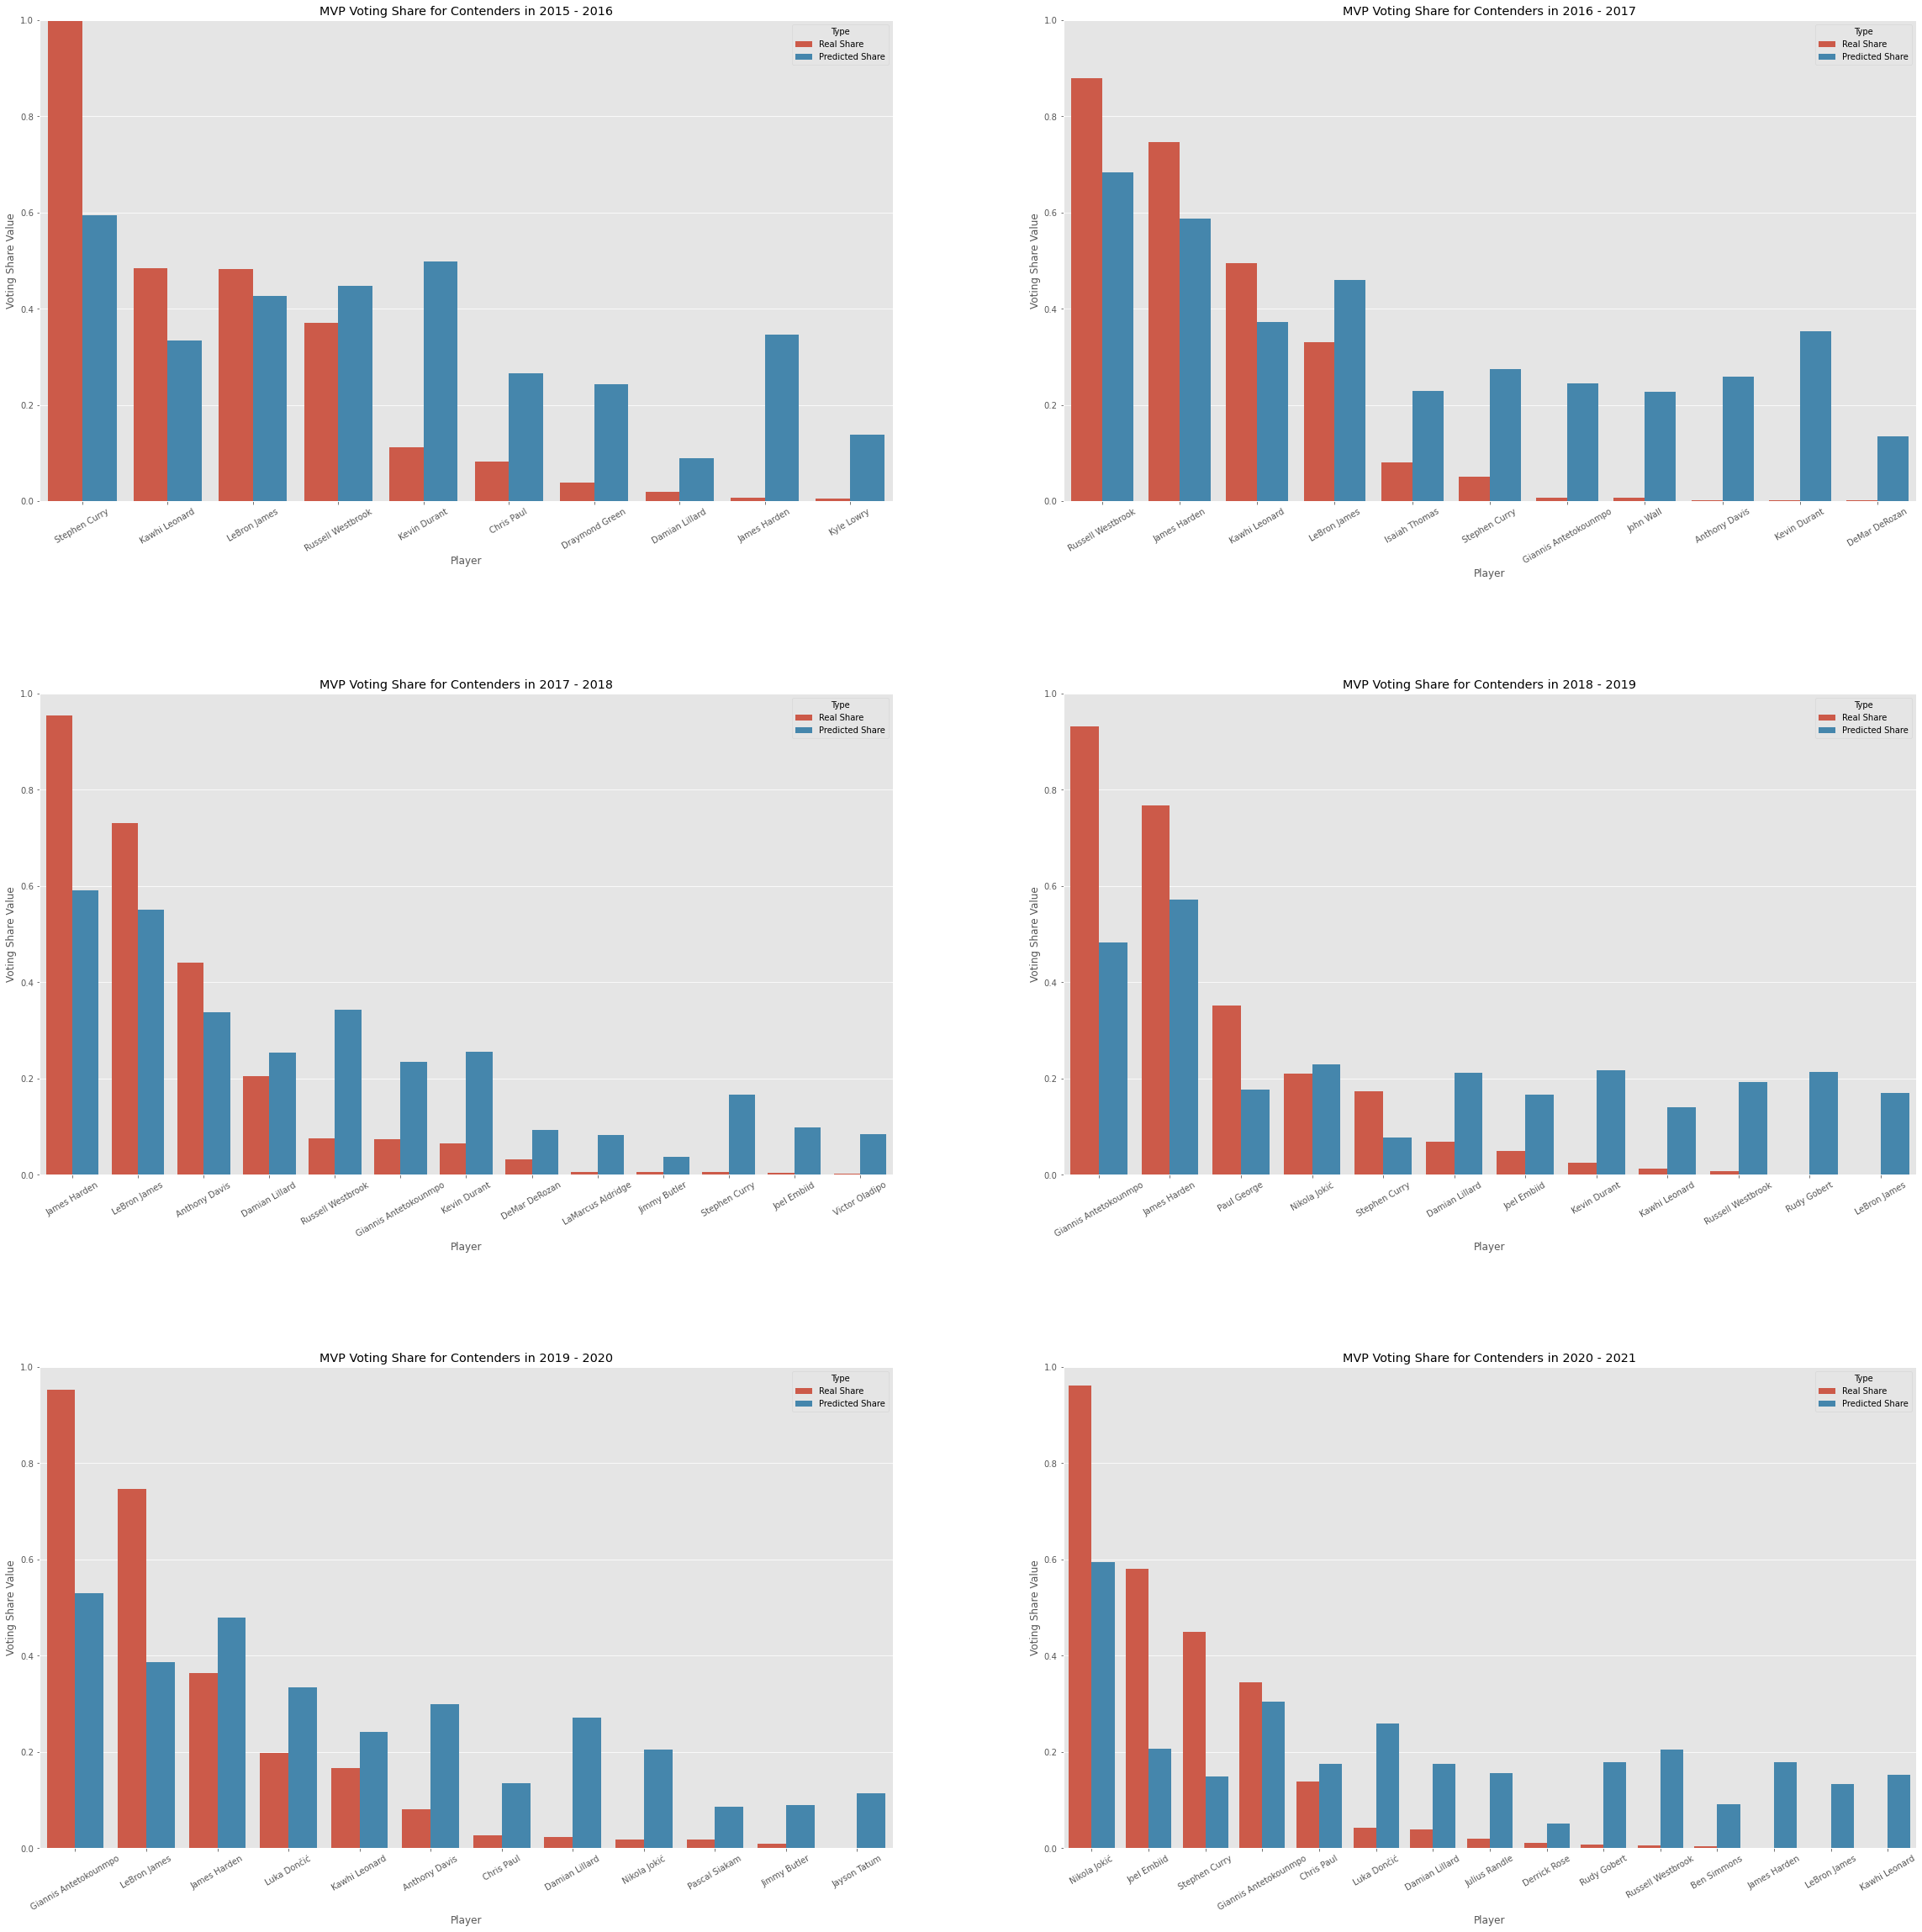

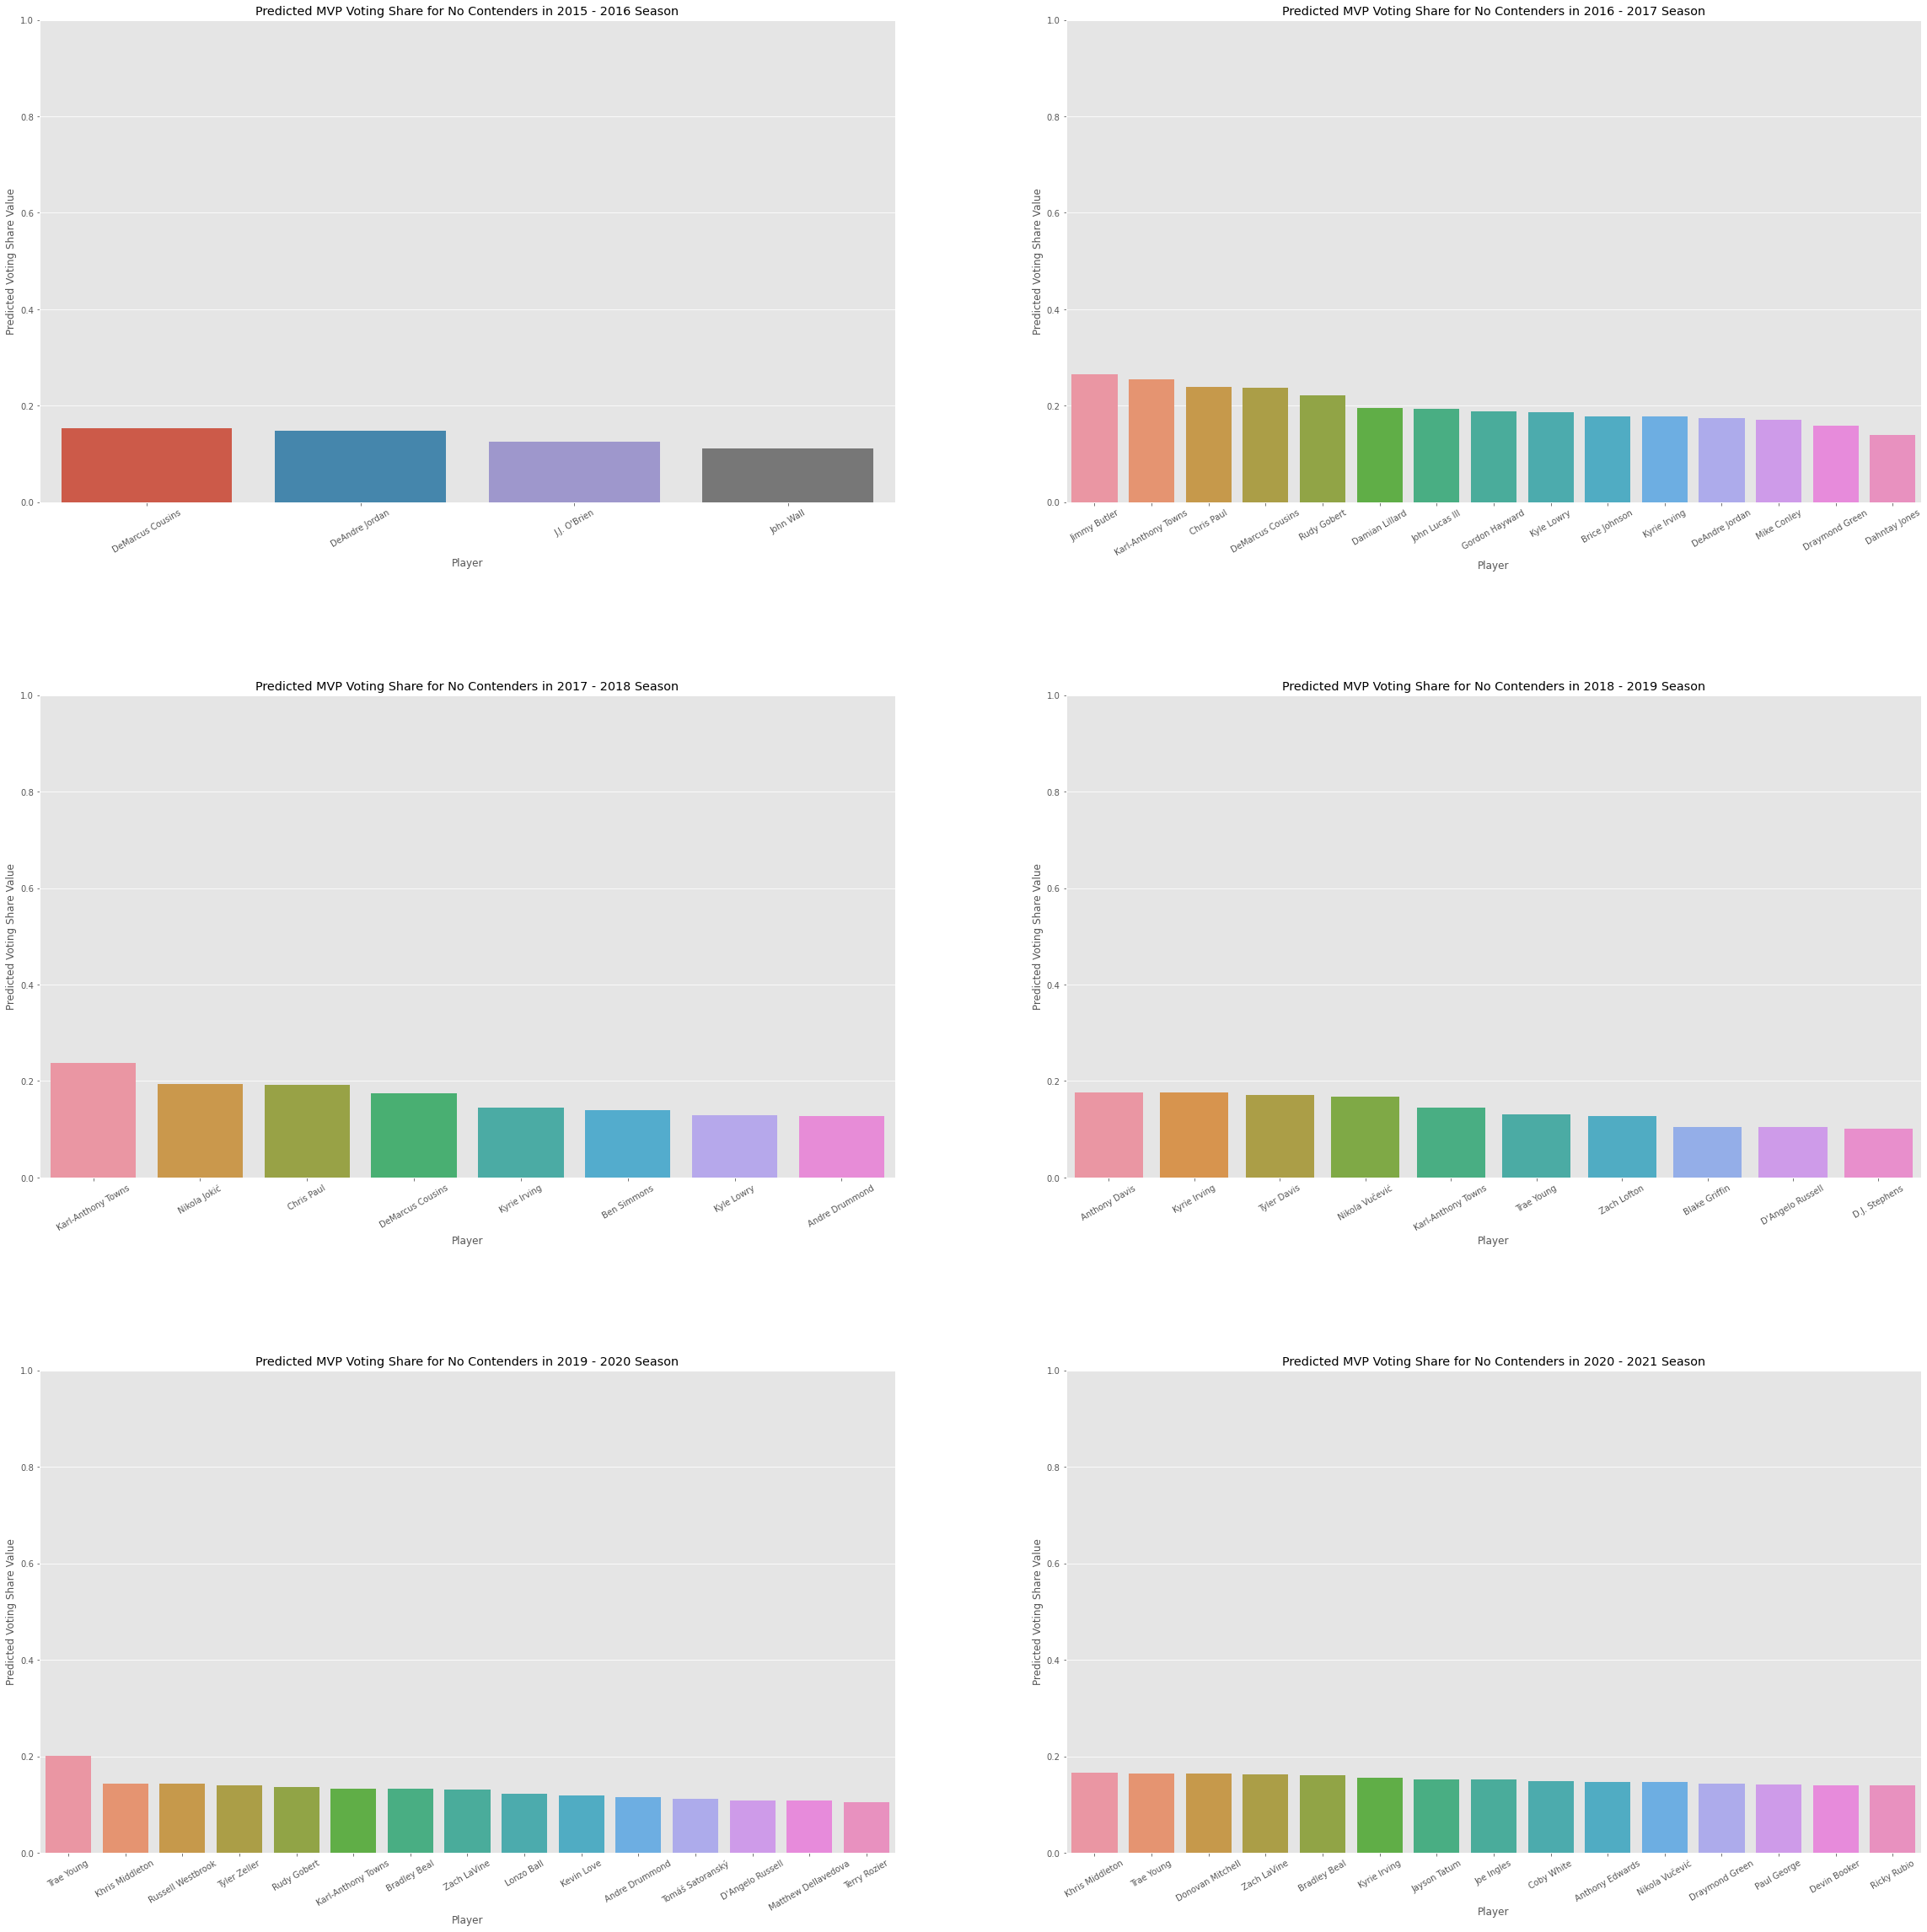

In [23]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe['DropPlayers'].players_list_)

In [24]:
# top_features = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['Importance']).sort_values('Importance', ascending = False)

In [25]:
# top_features[top_features['Importance'] > 0.005]